# Import data, identify contours and convert to points

ITEM classes: [-9999.0, -1287.0, -1040.0, -802.0, -481.0, -135.0, 128.0, 397.0, 716.0, 1101.0]


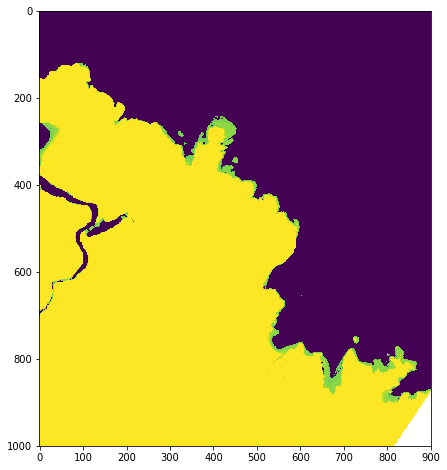

Contour 1 created and assigned elevation -1287.0
Contour 2 created and assigned elevation -1040.0
Contour 3 created and assigned elevation -802.0
Contour 4 created and assigned elevation -481.0
Contour 5 created and assigned elevation -135.0
Contour 6 created and assigned elevation 128.0
Contour 7 created and assigned elevation 397.0
Contour 8 created and assigned elevation 716.0
Contour 9 created and assigned elevation 1101.0
Contour 10 created and assigned elevation 1101.0


In [2]:
# Import libraries
import datacube
import glob
import scipy.ndimage
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import matplotlib.cm as cm
from osgeo import gdal
from scipy.interpolate import griddata
from skimage import measure
from matplotlib import pyplot as plt

"""
TODO: Investigate scipy.interpolate.RectBivariateSpline, scipy.interpolate.interp2d,
spipy.interpolate.RegularGridInterpolator
"""


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None  


# Select polygon
polygon_ID = 305

# Zoom-in for plots (has no effect on analysis but allows you to plot a zoomed-in subset)
# plotting_subset = np.index_exp[:, :]
plotting_subset = np.index_exp[1100:2100, 1300:2200]

# Import raster
filename = glob.glob("/g/data2/v10/ITEM/offset_products/ITEM_OFFSET_{}*.tif".format(polygon_ID))[0]
src_ds = gdal.Open(filename)
srcband = src_ds.GetRasterBand(1)
srcarray = srcband.ReadAsArray() 
yrows, xcols = srcarray.shape
prj = src_ds.GetProjection()
geotrans = src_ds.GetGeoTransform()
(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size) = geotrans

# Copy original data so array can be modified 
item_array = np.copy(srcarray)

# Set nodata to NaN, and force 0 values to a low negative  (-9999) to allow correct 
# contour extraction (i.e. make "0" data sit beneath the lowest ITEM tidal stage)
item_array[item_array == -6666] = np.nan
item_array[item_array == 0] = -9999 
item_classes = sorted(np.unique(item_array[~np.isnan(item_array)]))
print("ITEM classes: {}".format(item_classes))

# Plot original data
plt.figure(figsize = (8, 8))
plt.imshow(item_array[plotting_subset])  
plt.show()

# Set up output list and items to iterate over; subtract 1m from highest class to allow
# highest contour to calculate (otherwise, this height is read as being in NaN area)
contour_arrays = list()
class_list = item_classes[0:9] + [item_classes[9] - 1.0]

# For each item tidal class, find contour and save to list
for n, item_class in enumerate(class_list):
    
    # Extract contours and combine into one array
    contours = measure.find_contours(item_array, item_class)  
    contour_array = np.concatenate(contours)
    
    # Assign contours current item class + 1. For highest class only, assign median value 
    # to both lower and maximum bounds (i.e. highest class will be flat)
    elevation_value = item_classes[np.min((9, n + 1))]
    elevation_array = np.full((contour_array.shape[0], 1), fill_value = elevation_value)
    
    # Bind arrays and append to list
    contour_arrays.append(np.column_stack((contour_array, elevation_array)))
    print("Contour {0} created and assigned elevation {1}".format(n + 1, elevation_value))

# Concatenate all arrays and remove nodata
alldata = np.concatenate(contour_arrays)
alldata = alldata[~np.isnan(alldata).any(axis=1)]

# Convert cells to array of points; use geotransform to convert indices to coordinates
y_inds, x_inds = alldata[:,0], alldata[:,1]
centroids = [(y_ind * y_size + upleft_y + (y_size / 2.0),
              x_ind * x_size + upleft_x + (x_size / 2.0)) for (y_ind, x_ind, elev) in alldata]

# Convert to arrays for interpolation
points = np.array(centroids)
values = np.array(alldata[:,2])

# Write points to file for troubleshooting/verification
np.savetxt("output_data/contour_points.csv", 
           np.column_stack((points, values)), 
           delimiter = ",", 
           header = "y, x, elevation",
           comments = "")


# Interpolate points
Exports a DEM by interpolating previously extracted contours. This uses the `linear` method from `scipy.interpolate.griddata`, which computes a TIN/Delaunay triangulation of the input data using [Qhull](www.qhull.org) before performing linear barycentric interpolation on each triangle.

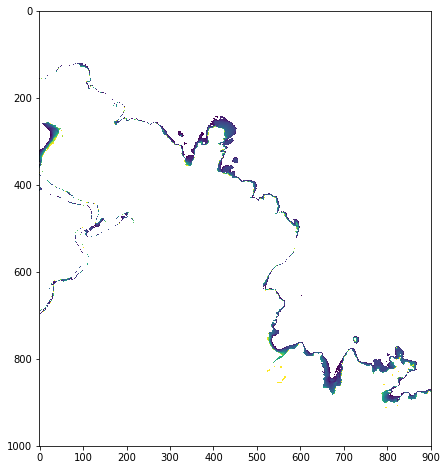

In [3]:
# Extract bounds of ITEM layer
minx = upleft_x
maxx = upleft_x + (x_size * xcols)
miny = upleft_y + (y_size * yrows)
maxy = upleft_y

# Create interpolation grid (from, to, by in metres)
grid_y, grid_x = np.mgrid[maxy:miny:1j * yrows,
                          minx:maxx:1j * xcols]

# Interpolate between points onto grid. This uses the 'linear' method from 
# scipy.interpolate.griddata, which computes a TIN/Delaunay triangulation of the input 
# data with Qhull and performs linear barycentric interpolation on each triangle
interpolated_array = griddata(points, values, (grid_y, grid_x), method = "linear")

# Mask out NaNs, zero values and max tidal stage from original ITEM offset layer
gooddata_mask = ((srcarray != -6666) & (srcarray != 0) & (srcarray != item_classes[9]))
interpolated_array[~gooddata_mask] = np.nan

# Plot
plt.figure(figsize = (8, 8))
plt.imshow(interpolated_array[plotting_subset])
plt.show()

# Export to tif
write_geotiff(fname = "output_data/dem_{}.tif".format(polygon_ID), 
              data = interpolated_array, 
              geo_transform = geotrans, 
              projection = prj, 
              nodata_val = np.nan)
